# Challenge #7: Interpretability and explainable ML

In this assignment, you will explore explainability using LIME on image classification. Your tasks are:

1. **get_lime_explanation: (3 points)**  
   Given a pretrained image classifier and an input image, generate a LIME explanation object.

2. **display_lime_explanation: (1 point)**  
   From the explanation object, extract and return a visualization (image and mask overlay) that highlights important superpixels.

3. **extract_feature_importance: (1 point)**  
   Extract a list of important feature (superpixel) contributions from the explanation object, sorted by importance.

4. **Task 4:** Apply a pretrained ResNet model on an input image and use LIME to generate and display explanations for the top 5 predicted classes.

After coding, answer three brief reflection questions on explainability methods.

*Total points: 9 (6 points for code tasks and 3 points for reflection questions).*

---

## Background on LIME

LIME (Local Interpretable Model-agnostic Explanations) is a popular method for explaining predictions of any classifier. For image classification, LIME works by:
- Perturbing the input image by turning superpixels on/off.
- Evaluating how these perturbations affect the prediction.
- Fitting a local, interpretable linear model to approximate the classifier's behavior near the instance.

The result is an explanation object that can produce:
- A list of feature contributions.
- A visualization (image with a mask overlay) highlighting which superpixels had the greatest influence on the prediction.

**Additional resources:**  
[Official LIME blog post](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)  
[Tutorial notebooks on their official GitHub repository](https://github.com/marcotcr/lime/tree/master/doc/notebooks)  
[General article reading about explainable machine learning | Medium](https://medium.com/michelle-and-ryan-explain-ml/explainable-and-interpretable-machine-learning-7e7c28bba4f2)

## Imports & Setup

In [1]:
!pip install lime

In [2]:
from lime import lime_image
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2
import json

import torch.nn.functional as F

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


## Task 1: Get LIME Explanation <font color='green'>(3 points)</font>

Generate and return a LIME explanation object for the given image and model.

In [3]:
def get_lime_explanation(model: torch.nn.Module, image: np.ndarray, top_labels: int = 5, num_samples: int = 1000):
    """
    Generate and return a LIME explanation object for the given image and model.

    Parameters:
        model (torch.nn.Module): A pretrained image classification model.
        image (np.ndarray): Input image in numpy array format (H x W x C).
        top_labels (int): Number of top labels to consider.
        num_samples (int): Number of perturbed samples to generate.

    Returns:
        explanation: A LIME explanation object (as returned by lime_image.LimeImageExplainer.explain_instance).
    """
    # TODO: Create an instance of LimeImageExplainer.
    explainer = lime_image.LimeImageExplainer()

    # TODO: Define a prediction function that accepts a batch of images as numpy arrays and returns prediction probabilities.
    def predict(images):
        # Convert images to torch tensors, preprocess them, and obtain predictions.
        # Adapted from https://pytorch.org/hub/pytorch_vision_resnet/
        transformations = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((256, 256)),
          transforms.CenterCrop(224),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        batch = torch.stack([transformations(i) for i in images], dim=0).to(device)
        logits = model.forward(batch)
        return F.softmax(logits, dim=1).cpu().detach().numpy()

    # TODO: Use the explainer to generate an explanation for the image.
    explanation = explainer.explain_instance(
      image,
      predict,
      top_labels=top_labels,
      hide_color=0,
      num_samples=num_samples
    )

    return explanation

## Task 2: Display LIME Explanation <font color='green'>(1 point)</font>

Implement a function that extracts and returns the visualization of the LIME explanation. This function should use the explanation object's method (such as `get_image_and_mask`) to generate an image with an overlay mask that highlights the most important superpixels.

The output should be a tuple: (explanation_image, mask), which you can then display using matplotlib.

In [4]:
# Utility function to visualise the LIME explanation
def visualiseExplanation(explanation_image, mask):
    # show the image boundary
    img_boundry = mark_boundaries(explanation_image/255.0, mask)
    plt.axis('off')
    plt.imshow(img_boundry)

def display_lime_explanation(explanation, image: np.ndarray, positive_only: bool = True, num_features: int = 5):
    """
    From the LIME explanation object, generate and return the visualization image and mask overlay.

    Parameters:
        explanation: The LIME explanation object.
        image (np.ndarray): The original image (H x W x C).
        positive_only (bool): Whether to show only features that positively influence the prediction.
        num_features (int): Number of superpixels to display.

    Returns:
        tuple: (explanation_image, mask) as produced by explanation.get_image_and_mask.
    """
    # TODO: Call explanation.get_image_and_mask with appropriate parameters.
    explanation_image, mask = explanation.get_image_and_mask(
          explanation.top_labels[0],
          positive_only=positive_only,
          num_features=num_features,
          hide_rest=False
      )

    return explanation_image, mask

## Task 3: Extract Feature Importance <font color='green'>(1 point)</font>

Implement a function that extracts a sorted list of feature (superpixel) contributions from the LIME explanation object. The function should return a list of tuples (feature_index, importance) sorted in descending order by importance.

In [6]:
def extract_feature_importance(explanation) -> list:
    """
    Extract and return a sorted list of feature contributions from the LIME explanation object.

    Returns:
        List[tuple]: Each tuple contains (feature_index, importance) sorted by importance (descending).
    """
    # TODO: Process the output to return a sorted list of tuples.
    # Note: an implicit assumption here is that we want feature importances towards
    # the top label
    feature_importances = explanation.local_exp[explanation.top_labels[0]]

    return feature_importances

## Task 4: Top 5 explanations from a pretrained ResNet model <font color='green'>(2 points)</font>

Use a pretrained ResNet model to predict the image classes and generate LIME explanations for the top 5 classes.

In [7]:
# Download ImageNet class label mappings
!wget https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true -O imagenet_class_index.json

--2025-03-06 22:42:14--  https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-06 22:42:14--  https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-06 22:42:14--  https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.1

In [8]:
from torchvision import models
import cv2

def get_resnet_lime_explanations(image: np.ndarray):
    """
    Use a pretrained ResNet model to predict the image classes and generate LIME explanations for the top 5 classes.

    This function should:
      1. Load a pretrained ResNet (e.g., ResNet18) from torchvision.
      2. Apply necessary preprocessing to the image.
      3. Obtain predictions and determine the top 5 classes.
      4. For each of the top 5 classes, generate a LIME explanation using get_lime_explanation().
      5. Return a dictionary mapping each top class label to its corresponding explanation visualization (image and mask).

    Boilerplate (e.g., label list) is provided below.

    Returns:
        dict: {class_label: (explanation_image, mask), ...} for top 5 classes.
    """
    # Predefined label list for demonstration (first 5 ImageNet classes).
    imagenet_labels = json.load(open("imagenet_class_index.json"))
    imagenet_labels = {int(key): value[1] for key, value in imagenet_labels.items()}

    model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
    model.eval()

    explanation = get_lime_explanation(model, image, top_labels=5)  # Replace with your code.

    explanations = {}

    top5_labels = explanation.top_labels # Replace with your code.
    for label in top5_labels:
        class_name = imagenet_labels.get(label, str(label))
        expl_img, mask = display_lime_explanation(explanation, image, positive_only=True, num_features=5)
        explanations[class_name] = (expl_img, mask)

    return explanations


## Reflection Questions (answer in brief)  <font color='green'>(1 point each)</font>

**Question 1:**  
What are the main advantages of using LIME for explaining image classification models?  
*Your Answer:*  

The fact it treats the model as a black box (and so can be applied to any image classfier, regardless of its internal mechanisms), and the fact its output is so easily human interpretable - it's _this_ part of the image that contributes to the model's confidence in this classification.

**Question 2:**  
How does LIME generate local explanations for a model's prediction, and why is this approach considered model-agnostic?  
*Your Answer:*  

It starts by dividing a model into visually distinct features ("superpixels") using an off the shelf segmentation algorithm. It then randomly blanks out some of these features, and passes them back through the model to see how its predictions change as parts of the image are hidden from it. By training a linear classifier to approximate the model on these blanked images, we can approximate what features are most important to model in predicting an image as a certain class.

This approach is considered model

**Question 3:**  
Discuss the trade-offs between model complexity and interpretability. How do these trade-offs impact both the performance of a model and its deployment in real-world, sensitive applications?
*Your Answer:*

The fundamental tradeoff between model complexity and interpretability in AI research thus far has been that, sadly, the more complex and opaque a model, the more powerful it tends to be. Work often prioritizes model performance on hard evaluation metrics, with understandability of the predictions produced left to the wayside. However: increasingly, organizations are opting to deploy "good-enough" models whose rationale can be explained (ultimately enabling higher accuracy & more accountable human-in-the-loop solutions) in sensitive applications.

---
### Autograder

Run this code cell at the end and do not change any code here.

(Note: I made a small change to have DummyModel be moved to `device`, to prevent torch from complaining that we have models on both the CPU and GPU. Running ResNet on the CPU seems to crash the kernel with an OOM error.)

mkdir: cannot create directory ‘datasets’: File exists
will be placed in the single file you specified.

--2025-03-06 22:42:15--  https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47018 (46K) [image/jpeg]
Saving to: ‘datasets/dog.jpg’

datasets/dog.jpg    100%[===================>]  45.92K  --.-KB/s    in 0.008s  

2025-03-06 22:42:15 (5.58 MB/s) - ‘datasets/dog.jpg’ saved [47018/47018]

FINISHED --2025-03-06 22:42:15--
Total wall clock time: 0.1s
Downloaded: 1 files, 46K in 0.008s (5.58 MB/s)


  0%|          | 0/100 [00:00<?, ?it/s]

Task 1 (get_lime_explanation): Passed (2 points)
Task 2 (display_lime_explanation): Passed (1 point)
Task 3 (extract_feature_importance): Passed (1 point)


  0%|          | 0/1000 [00:00<?, ?it/s]

top 5 label predictions:
1. basenji
2. toy_terrier
3. Ibizan_hound
4. Italian_greyhound
5. Boston_bull
Task 4 (ResNet LIME Explanations): Passed (2 points)
Total Code Score: 6 / 6
Reflection Questions: 3 points (graded manually)


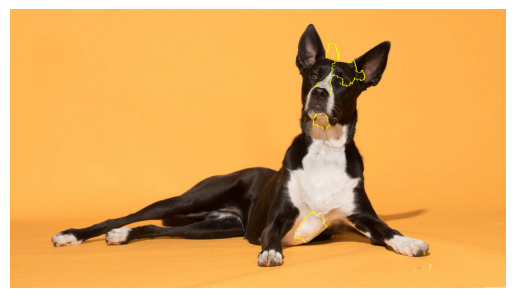

In [9]:
!mkdir datasets
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg -O datasets/dog.jpg

# ================================
# Pytest Tests for Challenge #7: LIME Explainability
# ================================

import pytest
import numpy as np
import torch.nn as nn

def run_tests_and_accumulate_score():
    total_code_points = 6  # Tasks 1-4: 2 + 1 + 1 + 2 = 6 points
    score = 0

    # Prepare dummy setup for testing:
    # Create a dummy image (224 x 224 x 3) as a numpy array.
    dummy_image = Image.open("datasets/dog.jpg")
    dummy_image = np.array(dummy_image)

    # Dummy model for LIME explanation tests (for Task 1, 2, 3)
    class DummyModel(nn.Module):
        def __init__(self):
            super(DummyModel, self).__init__()
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(224*224*3, 2)  # Assume 2 classes for simplicity.
        def forward(self, x):
            x = self.flatten(x)
            return torch.softmax(self.fc(x), dim=1)

    dummy_model = DummyModel().to(device)

    # ------------------------------
    # Task 1: get_lime_explanation (2 points)
    # ------------------------------
    try:
        explanation = get_lime_explanation(dummy_model, dummy_image, top_labels=2, num_samples=100)
        assert explanation is not None, "get_lime_explanation() returned None."
        # Check for at least one expected method (as_list or get_image_and_mask).
        has_method = hasattr(explanation, "as_list") or hasattr(explanation, "get_image_and_mask")
        assert has_method, "Explanation object lacks expected methods."
        score += 2
        print("Task 1 (get_lime_explanation): Passed (2 points)")
    except AssertionError as e:
        print("Task 1 (get_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 2: display_lime_explanation (1 point)
    # ------------------------------
    try:
        expl_img, mask = display_lime_explanation(explanation, dummy_image, positive_only=True, num_features=5)
        assert expl_img is not None, "display_lime_explanation() returned None for explanation image."
        assert mask is not None, "display_lime_explanation() returned None for mask."
        assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
        assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
        score += 1
        print("Task 2 (display_lime_explanation): Passed (1 point)")
    except AssertionError as e:
        print("Task 2 (display_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 3: extract_feature_importance (1 point)
    # ------------------------------
    try:
        feature_list = extract_feature_importance(explanation)
        assert isinstance(feature_list, list), "extract_feature_importance() should return a list."
        if feature_list:
            first_item = feature_list[0]
            assert isinstance(first_item, tuple) and len(first_item) == 2, "Each item should be a tuple (feature, importance)."
        score += 1
        print("Task 3 (extract_feature_importance): Passed (1 point)")
    except AssertionError as e:
        print("Task 3 (extract_feature_importance): Failed -", e)

    # ------------------------------
    # Task 4: Pretrained ResNet LIME Explanations (2 points)
    # ------------------------------
    try:
        explanations = get_resnet_lime_explanations(dummy_image)
        assert isinstance(explanations, dict), "get_resnet_lime_explanations() should return a dictionary."
        # Expect 5 keys corresponding to top 5 classes.
        assert len(explanations) == 5, "Expected explanations for top 5 classes."
        print('top 5 label predictions:')
        for i, (label, (expl_img, mask)) in enumerate(explanations.items()):
            assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
            assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
            print(f'{i+1}. {label}')
            # plt.subplot(1, 5, i+1)
        expl_img, mask = next(iter(explanations.values()))
        visualiseExplanation(expl_img, mask)
        score += 2
        print("Task 4 (ResNet LIME Explanations): Passed (2 points)")
    except AssertionError as e:
        print("Task 4 (ResNet LIME Explanations): Failed -", e)

    print(f"Total Code Score: {score} / {total_code_points}")

    # Reflection questions are graded manually.
    print("Reflection Questions: 3 points (graded manually)")

# Run the autograder.
run_tests_and_accumulate_score()